In [40]:
from keras.models import load_model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [41]:
Z_DIM = 100

sign_swap = lambda x, k: x * np.sign(k)

In [42]:
generator = load_model("generator.h5")
encoder = load_model("encoder.h5")

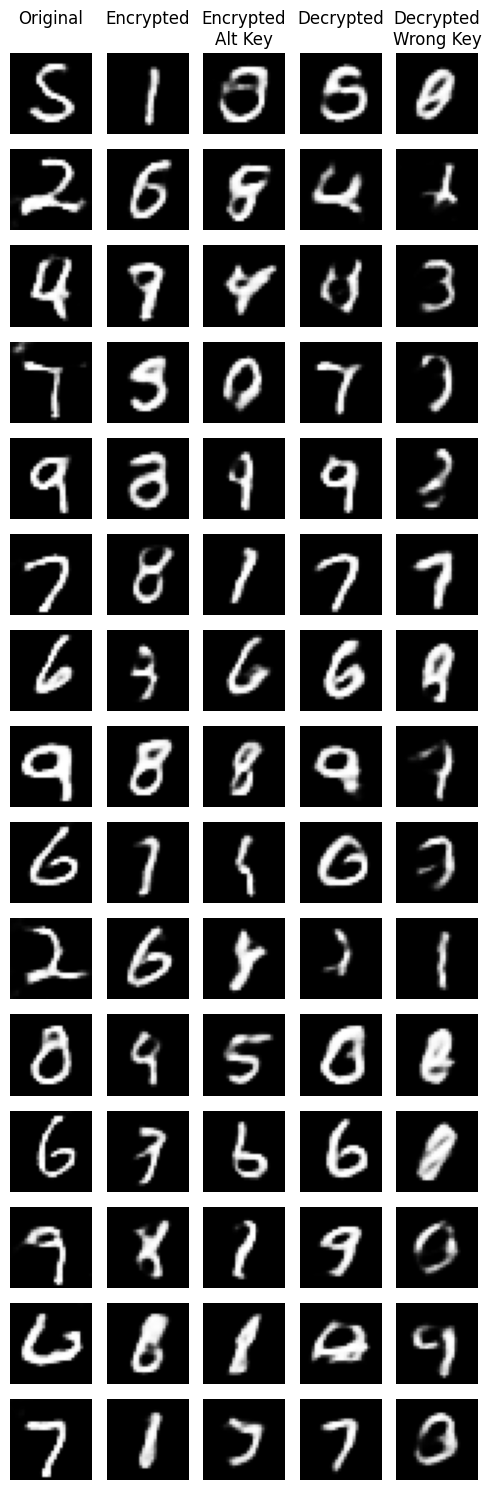

In [43]:
key = np.random.uniform(-1, 1, size=(Z_DIM,))
alt_key = np.random.uniform(-1, 1, size=(Z_DIM,))
pto_images = mnist.load_data()[0][0]
pto_images = pto_images[np.random.randint(0, pto_images.shape[0], size=15)]
pto_images = (pto_images.astype(np.float32) - 127.5) / 127.5

pto = encoder(pto_images)
pto_images = generator(pto)
cto = sign_swap(pto, key)
cto_images = generator(cto)
alt_cto = sign_swap(pto, alt_key)
alt_cto_images = generator(alt_cto)
ctr = encoder(cto_images)
ptr = sign_swap(ctr, key)
ptr_images = generator(ptr)
ptw = sign_swap(ctr, alt_key)
ptw_images = generator(ptw)

plt.figure(figsize=(5, 15))
cols = ["Original\n", "Encrypted\n", "Encrypted\nAlt Key", "Decrypted\n", "Decrypted\nWrong Key"]
for i in range(15):
    plt.subplot(15, 5, 5*i + 1)
    plt.imshow(pto_images[i], cmap="gray")
    plt.axis("off")
    if i == 0: plt.title(cols[0])
    plt.subplot(15, 5, 5*i + 2)
    plt.imshow(cto_images[i], cmap="gray")
    plt.axis("off")
    if i == 0: plt.title(cols[1])
    plt.subplot(15, 5, 5*i + 3)
    plt.imshow(alt_cto_images[i], cmap="gray")
    plt.axis("off")
    if i == 0: plt.title(cols[2])
    plt.subplot(15, 5, 5*i + 4)
    plt.imshow(ptr_images[i], cmap="gray")
    plt.axis("off")
    if i == 0: plt.title(cols[3])
    plt.subplot(15, 5, 5*i + 5)
    plt.imshow(ptw_images[i], cmap="gray")
    plt.axis("off")
    if i == 0: plt.title(cols[4])
plt.tight_layout()
plt.savefig("results.png")
plt.show()